 # Preprocessing data
Image processing basics.

**Acknowledgment**    
Adapted some content below from Bioimage Analysis Notebook compilation at:    
https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/intro.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from fastplotlib.widgets import ImageWidget

In [2]:
arr_image = np.array([
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,], # row 0
   [0, 0, 1, 1, 0, 0, 1, 1, 0, 0,], # row 1
   [0, 0, 1, 1, 0, 0, 1, 1, 0, 0,], # row 2
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,], # row 3
   [0, 0, 0, 0, 1, 0, 0, 0, 0, 0,], # row 4
   [0, 1, 0, 0, 1, 1, 0, 0, 1, 0,], # row 5
   [0, 0, 1, 0, 0, 0, 0, 1, 1, 0,], # row 6
   [0, 0, 1, 1, 1, 1, 1, 1, 0, 0,], # row 7 
   [0, 0, 0, 1, 1, 1, 1, 0, 0, 0,], # row 8
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,], # row 9 
]);

The shape attribute of an array returns a tuple that contains the lengths of the array along each dimension. For 2d arrays the shape returns (rows, columns). 

In [3]:
arr_image.shape

(10, 10)

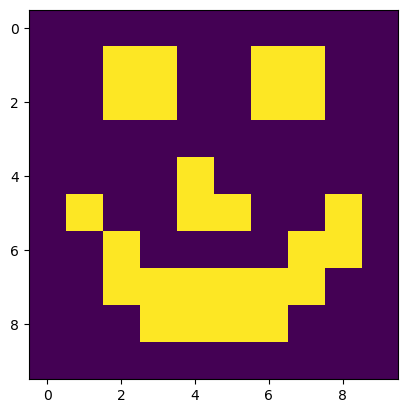

In [4]:
plt.imshow(arr_image)

## 3D arrays
When dealing with 3D volumes, or movies with stacks of images over time, the 3d arrays typically have dimensions `(frames, row, column)`. Calcium imaging applications like `caiman` thankfully deal with greyscale image data, so we'll only have to handle 3d arrays with dimensions `num_frames x rows x columns`.

Individual rgb images are *(row x column x 3)* arrays, where the final three arrays in the third dimension are R, G, and B channels respectively. 

If you had a 1000-frame movie with RGB channels, and each image has 600 rows and 400 columns, you will end up with a 4d array with the following shape: 

    (1000, 600, 400, 3)

But we will not deal with that case here.

### RGB image example

In [5]:
rgb_image = np.random.rand(10,10,3)
rgb_image.shape

(10, 10, 3)

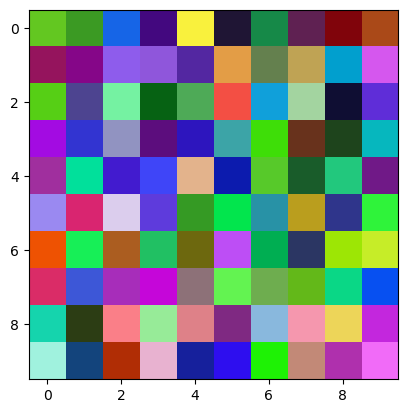

In [6]:
plt.imshow(rgb_image)

### Image stack example

In [7]:
my_stack = np.random.rand(100, 20,20)

View in fastplotlib

In [11]:
iw = ImageWidget(
    data=my_stack, 
    cmap="gnuplot2"
)
iw.show()

RFBOutputContext()

In [12]:
iw.plot.canvas.close()

## Cropping and subsampling
### Crop in time

In [13]:
my_stack_ct = my_stack[10:]
my_stack_ct.shape

(90, 20, 20)

### Crop in space

In [14]:
my_stack_cs = my_stack[:, 5:10, 15:20]
my_stack_cs.shape

(100, 5, 5)

In [15]:
iw = ImageWidget(
    data=my_stack_cs, 
    cmap="gnuplot2"
)
iw.show()

RFBOutputContext()

In [16]:
iw.plot.canvas.close()

### Subsampling
You can subsample in space or time by indicating a step size as the third argument. If you leave the first arguments blank, it will subsample across all the images (or rows/columns). For instance, to sample every fifth frame;

    subsampled = my_stack[::5]

In [17]:
my_stack_sst = my_stack[::5]
my_stack_sst.shape

(20, 20, 20)

## Filtering (convolution)
### Smoothing with a gaussian

In [18]:
from skimage.filters import gaussian
from skimage import filters

In [19]:
test_image = np.zeros((10,10))
test_image[5,3] = 1
test_image[5,7] = 1

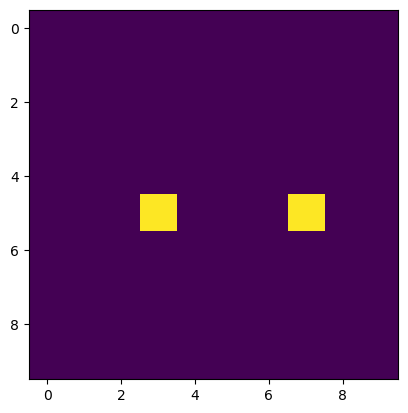

In [20]:
plt.imshow(test_image);

Convolve with gaussian with sigma parameters of different widths.

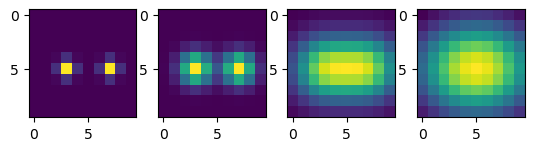

In [21]:
blurred05 = gaussian(test_image, sigma=0.5)
blurred1 = gaussian(test_image, sigma=1)
blurred2 = gaussian(test_image, sigma=2)
blurred3 = gaussian(test_image, sigma=3)

fig, axs = plt.subplots(1, 4)
axs[0].imshow(blurred05)
axs[1].imshow(blurred1)
axs[2].imshow(blurred2)
axs[3].imshow(blurred3);

### Denoising
Median, mean, gaussian filter

In [22]:
from skimage.io import imread

In [23]:
noisy_mri = imread('Haase_MRT_tfl3d1.tif')[90]

In [24]:
noisy_mri_zoom = noisy_mri[50:100, 50:100]

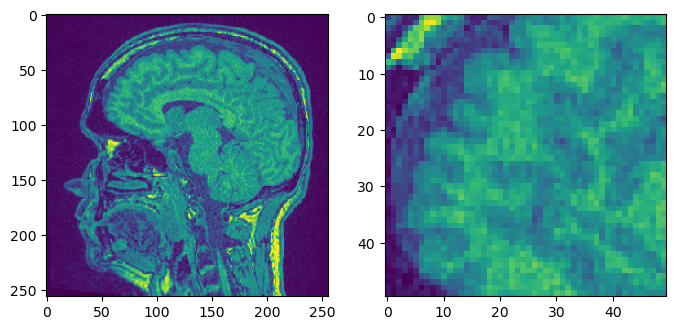

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
axs[0].imshow(noisy_mri)
axs[1].imshow(noisy_mri_zoom);

Now let's convolve with three denoising filters and compare them for how well they preserve contrast/lines

In [26]:
from skimage.morphology import disk

Disk defines the "local" neighborhood for median/mean calculation for the convolution operation.

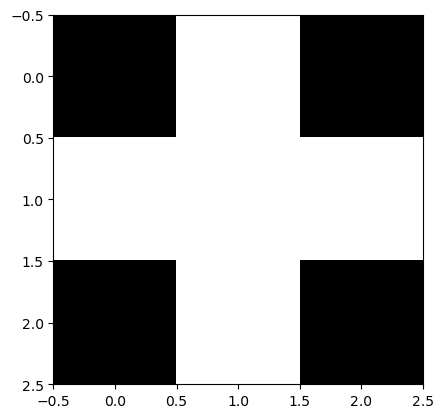

In [27]:
disk1 = disk(1)
plt.imshow(disk1, cmap='gray');

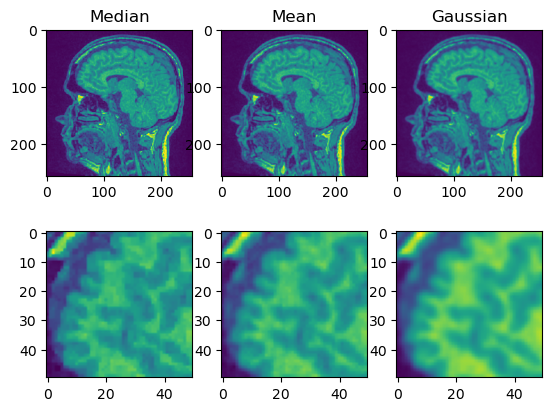

In [28]:
median_filtered = filters.median(noisy_mri, disk(1))
mean_filtered = filters.rank.mean(noisy_mri, disk(1))
gaussian_filtered = filters.gaussian(noisy_mri, sigma=1)

fig, axs = plt.subplots(2, 3)

# first row
axs[0, 0].imshow(median_filtered)
axs[0, 0].set_title("Median")
axs[0, 1].imshow(mean_filtered)
axs[0, 1].set_title("Mean")
axs[0, 2].imshow(gaussian_filtered)
axs[0, 2].set_title("Gaussian")

# second row
axs[1, 0].imshow(median_filtered[50:100, 50:100])
axs[1, 1].imshow(mean_filtered[50:100, 50:100])
axs[1, 2].imshow(gaussian_filtered[50:100, 50:100]);

You can see the median filter is edge-preserving (median filter at each location replaces the value by the median of the local values).

## Morphological Operations
Erosion, dilation, opening, closing

If this was a broader notebook on image processing relevant to caiman, we'd have this 

https://scikit-image.org/docs/dev/auto_examples/applications/plot_morphology.html

# Spatial filter to denoise

In [29]:
from caiman import load_memmap
import numpy as np

In [30]:
def caiman_memmap_reader(path: str, mode: str = "r") -> np.memmap:
    Yr, dims, T = load_memmap(path, mode)
    return np.reshape(Yr.T, [T] + list(dims), order="F")

In [36]:
movie = caiman_memmap_reader("../noisy_els__d1_512_d2_512_d3_1_order_F_frames_9153_.mmap", mode="r+")

In [37]:
from skimage.restoration import denoise_bilateral
from functools import partial
from fastplotlib import ImageWidget

# Visualization

In [39]:
iw = ImageWidget(
    movie,
    vmin_vmax_sliders=True,
    cmap="gnuplot2"
)
iw.show()

RFBOutputContext()

## Denoise using `frame_apply`

In [40]:
iw.frame_apply = {0: lambda frame: denoise_bilateral(frame, win_size=5)}

# Write denoised movie directly to memmap file

If memmap files are opened in `"r+"` mode the modifications will be saved to disk. You can then use this memmap file downstream, such as for CNMF.

### Consequences

1. Components could become mixed because this is a weighted spatial mean
2. Can be performed before or after mcorr
3. Would be better to use denoised movie to get the components, and then refine the components using the mask from the denoised movie.

Many other options exist for spatial filters:

- https://scikit-image.org/docs/stable/auto_examples/filters/plot_denoise.html
- https://scikit-image.org/docs/stable/api/skimage.restoration.html

# Temporal filtering: Rolling mean

**You want to do this AFTER motion correction**

In [42]:
window_size = 23

iw = ImageWidget(
    movie,
    window_funcs={"t": (np.mean, window_size)},
    vmin_vmax_sliders=True,
    cmap="gnuplot2"
)
iw.show()

RFBOutputContext()

In [43]:
movie.shape

(9153, 512, 512)